In [180]:
import os
import cv2
import glob
import ntpath
import random
import warnings
import numpy as np
import seaborn as sns

from imblearn import over_sampling
from keras.utils import np_utils 
from keras.models import Model
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler,ModelCheckpoint
from keras.metrics import categorical_accuracy, categorical_crossentropy
from keras.layers import Input, Convolution2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, AveragePooling2D, Concatenate, GlobalMaxPooling2D
from keras.layers.advanced_activations import ReLU

warnings.filterwarnings("ignore")

In [144]:
USE_DROPOUT = False
LEARN_RATE = 0.001
Height = 128
Weight = 128
Channel= 3

In [ ]:
# #################################################################################
# #数据平衡处理
# df_1 = df_train.loc[df_train["cancer_label"]==1]
# df_0 = df_train.loc[df_train["cancer_label"]==0]
# df_1_add1 = df_1.sample(379)
# df_1_add2 = df_1.sample(378)
# df_1 = pandas.concat([df_1,df_1_add1,df_1_add2])
# df_train = pandas.concat([df_1,df_0])

Get train/holdout files.
Full Count:  91564
Orginal Grade_0:  18873
Orginal Grade_1:  18462
Orginal Grade_2:  12797
Orginal Grade_3:  31434
Orginal Grade_4:  9998
Train Count Grade_0:  16985 , Holdout Count Grade_0:  1888
Train Count Grade_1:  16615 , Holdout Count Grade_1:  1847
Train Count Grade_2:  11517 , Holdout Count Grade_2:  1280
Train Count Grade_3:  28290 , Holdout Count Grade_3:  3144
Train Count Grade_4:  8998 , Holdout Count Grade_4:  1000
Train Count:  82405 , Holdout Count:  9159
Train Sample_X:  141450 , Train Sample_Y:  141450
Train Count:  141450 , Holdout Count:  9159
Train Count:  141450 , Holdout Count:  9159
________________________________________________________________________________________________________________________
Layer (type)                           Output Shape               Param #       Connected to                            
input (InputLayer)                     (None, 128, 128, 3)        0                                                     

Epoch 1/10
learnrate:  0.001  epoch:  0
10000/10000 [==============================] - 1375s 137ms/step - loss: 0.3839 - categorical_accuracy: 0.8569 - categorical_crossentropy: 0.3839 - val_loss: 0.7697 - val_categorical_accuracy: 0.7232 - val_categorical_crossentropy: 0.7697

Epoch 00001: saving model to workdir/model_liver_CNN__e01-0.7697.hd5
Epoch 2/10
learnrate:  0.001  epoch:  1
10000/10000 [==============================] - 1444s 144ms/step - loss: 0.2346 - categorical_accuracy: 0.9145 - categorical_crossentropy: 0.2346 - val_loss: 0.5253 - val_categorical_accuracy: 0.8111 - val_categorical_crossentropy: 0.5253

Epoch 00002: saving model to workdir/model_liver_CNN__e02-0.5253.hd5
Epoch 3/10
learnrate:  0.001  epoch:  2
10000/10000 [==============================] - 1421s 142ms/step - loss: 0.1812 - categorical_accuracy: 0.9339 - categorical_crossentropy: 0.1812 - val_loss: 0.7659 - val_categorical_accuracy: 0.7503 - val_categorical_crossentropy: 0.7659

Epoch 00003: saving model

KeyboardInterrupt: 

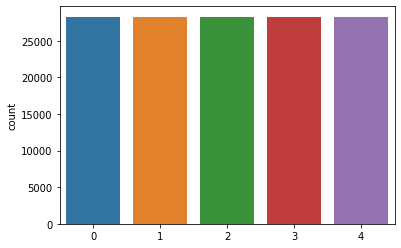

In [185]:
if __name__ == "__main__":
    
    if True:
            
        train(model_name="liver_CNN", load_weights_path=None)      
        

In [166]:
def train(model_name, load_weights_path):
    
    batch_size = 16

    #获得训练和测试集合，以：路径、class label的形式保存
    train_files, holdout_files = get_train_holdout_files(train_percentage=90)

    #训练数据集
    train_gen = data_generator(batch_size, train_files, train_set=True)

    #测试数据集
    holdout_gen = data_generator(batch_size, holdout_files, train_set=False)

    #动态设置学习率
    learnrate_scheduler = LearningRateScheduler(step_decay)

    #获取model
    model = get_net(load_weight_path=load_weights_path)

    checkpoint = ModelCheckpoint("workdir/model_" + model_name + "_"  + "_e" + "{epoch:02d}-{val_loss:.4f}.hd5", monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

    #model.fit_generator(generator=train_gen, samples_per_epoch=len(train_files), nb_epoch=10, verbose=1, validation_data=holdout_gen, nb_val_samples=len(holdout_files), class_weight="auto", callbacks=[checkpoint, learnrate_scheduler])
    model.fit_generator(generator=train_gen, samples_per_epoch=10000, nb_epoch=10, verbose=1, validation_data=holdout_gen, nb_val_samples=len(holdout_files), class_weight="auto", callbacks=[checkpoint, learnrate_scheduler])

    model.save("workdir/model_" + model_name + "_end.hd5")

In [151]:
def step_decay(epoch):
    res = 0.001
    if epoch > 100:
        res = 0.0001
    print("learnrate: ", res, " epoch: ", epoch)
    return res

In [186]:
def get_net(input_shape=(Height, Weight, Channel), load_weight_path=None) -> Model:  #期待返回类型为model
    
    inputs = Input(shape=input_shape, name="input")
    x = inputs
    
    ##################################################################################################################
    x_ident_1 = x
    x_ident_1 = AveragePooling2D(pool_size=(2, 2), strides=(2, 2), border_mode='valid')(x_ident_1)
    # 1st layer group
    x = Convolution2D(16, 3, 3, activation=None, border_mode='same', name='conv1a', subsample=(1, 1))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Convolution2D(16, 3, 3, activation=None, border_mode='same', name='conv1b', subsample=(1, 1))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), border_mode='valid', name='pool1')(x)
    x = Concatenate(axis=3)([x,x_ident_1])
    
    ##################################################################################################################
    x_ident_1 = AveragePooling2D(pool_size=(2, 2), strides=(2, 2), border_mode='valid')(x_ident_1)
    x_ident_2 = AveragePooling2D(pool_size=(2, 2), strides=(2, 2), border_mode='valid')(x)
    # 2nd layer group
    x = Convolution2D(32, 3, 3, activation=None, border_mode='same', name='conv2a', subsample=(1, 1))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Convolution2D(32, 3, 3, activation=None, border_mode='same', name='conv2b', subsample=(1, 1))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), border_mode='valid', name='pool2')(x)
    x = Concatenate(axis=3)([x,x_ident_1,x_ident_2])

    ##################################################################################################################
    x_ident_1 = AveragePooling2D(pool_size=(2, 2), strides=(2, 2), border_mode='valid')(x_ident_1)
    x_ident_2 = AveragePooling2D(pool_size=(2, 2), strides=(2, 2), border_mode='valid')(x_ident_2)
    x_ident_3 = AveragePooling2D(pool_size=(2, 2), strides=(2, 2), border_mode='valid')(x)
    # 3rd layer group
    x = Convolution2D(64, 3, 3, activation=None, border_mode='same', name='conv3a', subsample=(1, 1))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Convolution2D(64, 3, 3, activation=None, border_mode='same', name='conv3b', subsample=(1, 1))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), border_mode='valid', name='pool3')(x)
    x = Concatenate(axis=3)([x,x_ident_1,x_ident_2,x_ident_3])
     
    ##################################################################################################################
    x_ident_1 = AveragePooling2D(pool_size=(2, 2), strides=(2, 2), border_mode='valid')(x_ident_1)
    x_ident_2 = AveragePooling2D(pool_size=(2, 2), strides=(2, 2), border_mode='valid')(x_ident_2)
    x_ident_3 = AveragePooling2D(pool_size=(2, 2), strides=(2, 2), border_mode='valid')(x_ident_3)
    x_ident_4 = AveragePooling2D(pool_size=(2, 2), strides=(2, 2), border_mode='valid')(x)
    # 4th layer group
    x = Convolution2D(128, 3, 3, activation=None, border_mode='same', name='conv4a', subsample=(1, 1),)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Convolution2D(128, 3, 3, activation=None, border_mode='same', name='conv4b', subsample=(1, 1),)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), border_mode='valid', name='pool4')(x)
    x = Concatenate(axis=3)([x,x_ident_1,x_ident_2,x_ident_3,x_ident_4])
    
    x = GlobalMaxPooling2D()(x)
    x = BatchNormalization(name="final_features")(x)
    
    ##################################################################################################################
    if USE_DROPOUT:
        x = Dropout(p=0.3)(x)
        
    x = Dense(64, activation='relu')(x)
    out_class = Dense(5, activation='softmax', name='out_class')(x)

    model = Model(input=inputs, output=out_class)
    
    if load_weight_path is not None:
        model.load_weights(load_weight_path, by_name=False)

    #编译模型
    model.compile(optimizer=SGD(lr=LEARN_RATE, momentum=0.9, nesterov=True), loss={ "out_class": "categorical_crossentropy" }, metrics={"out_class": [categorical_accuracy, categorical_crossentropy] } )
    model.summary(line_length=120)

    return model

In [187]:
get_net()

________________________________________________________________________________________________________________________
Layer (type)                           Output Shape               Param #       Connected to                            
input (InputLayer)                     (None, 128, 128, 3)        0                                                     
________________________________________________________________________________________________________________________
conv1a (Conv2D)                        (None, 128, 128, 16)       448           input[0][0]                             
________________________________________________________________________________________________________________________
batch_normalization_41 (BatchNormaliza (None, 128, 128, 16)       64            conv1a[0][0]                            
________________________________________________________________________________________________________________________
re_lu_37 (ReLU)                 

In [165]:
def data_generator(batch_size, record_list, train_set):
    
    while True:
        
        batch_index = 0
        image_list = []
        label_list = []

        if train_set:
            random.shuffle(record_list)

        #逐一遍历所有数据
        for index, record_item in enumerate(record_list):

            sample_path = record_item[0]
            sample_label = record_item[1]

            #转换成多分类标签
            sample_label = np_utils.to_categorical(sample_label,5)  

            #读取图片、修改尺寸、标准化
            sample_image = cv2.imread(sample_path)
            sample_image = (sample_image - np.average(sample_image)) / np.std(sample_image)
            sample_image = sample_image.reshape(1, sample_image.shape[0], sample_image.shape[1], 3)

            #数据增强
            if train_set:  
                if random.randint(0, 100) > 50:
                    sample_image = np.fliplr(sample_image)
                if random.randint(0, 100) > 50:
                    sample_image = np.flipud(sample_image)
                if random.randint(0, 100) > 50:
                    sample_image = sample_image[:,::-1]
                if random.randint(0, 100) > 50:
                    sample_image = sample_image[::-1, :]

            #添加数据
            image_list.append(sample_image)
            label_list.append(sample_label)
            batch_index += 1

            if batch_index >= batch_size:
                x = np.vstack(image_list)
                y = np.vstack(label_list)
                yield x, y
                image_list = []
                label_list = []
                batch_index = 0

In [155]:
def get_train_holdout_files(train_percentage=90):
    
    print("Get train/holdout files.")
        
    src_dir = "D:/jupyter-notebook/LiverCancer/Image_Nuclei/images/"
    file_paths = []

    for fold_1 in os.listdir(src_dir):

        for fold_2 in os.listdir(src_dir+fold_1+"/"):

            file_paths = file_paths + [file_path for file_path in glob.glob(src_dir+fold_1+"/"+fold_2+"/*.jpg")]
        
    print("Full Count: ",len(file_paths))
    
    #####################################################################################
    samples_grade_0 = []
    samples_grade_1 = []
    samples_grade_2 = []
    samples_grade_3 = []
    samples_grade_4 = []
    
    for index, sample_path in enumerate(file_paths):
        
        if "grade0" in sample_path:
            samples_grade_0 += [ [sample_path, 0] ]
        elif "grade1" in sample_path:
            samples_grade_1 += [ [sample_path, 1] ]
        elif "grade2" in sample_path:
            samples_grade_2 += [ [sample_path, 2] ]
        elif "grade3" in sample_path:
            samples_grade_3 += [ [sample_path, 3] ]
        elif "grade4" in sample_path:
            samples_grade_4 += [ [sample_path, 4] ]
        
    print("Orginal Grade_0: ", len(samples_grade_0))
    print("Orginal Grade_1: ", len(samples_grade_1))
    print("Orginal Grade_2: ", len(samples_grade_2))
    print("Orginal Grade_3: ", len(samples_grade_3))
    print("Orginal Grade_4: ", len(samples_grade_4))
    
    #####################################################################################
    #分割训练数据和测试数据
    train_count_grade_0 = int((len(samples_grade_0) * train_percentage) / 100)
    train_count_grade_1 = int((len(samples_grade_1) * train_percentage) / 100)
    train_count_grade_2 = int((len(samples_grade_2) * train_percentage) / 100)
    train_count_grade_3 = int((len(samples_grade_3) * train_percentage) / 100)
    train_count_grade_4 = int((len(samples_grade_4) * train_percentage) / 100)
    train_samples_grade_0 = samples_grade_0[:train_count_grade_0]
    train_samples_grade_1 = samples_grade_1[:train_count_grade_1]
    train_samples_grade_2 = samples_grade_2[:train_count_grade_2]
    train_samples_grade_3 = samples_grade_3[:train_count_grade_3]
    train_samples_grade_4 = samples_grade_4[:train_count_grade_4]
    holdout_samples_grade_0 = samples_grade_0[train_count_grade_0:]
    holdout_samples_grade_1 = samples_grade_1[train_count_grade_1:]
    holdout_samples_grade_2 = samples_grade_2[train_count_grade_2:]
    holdout_samples_grade_3 = samples_grade_3[train_count_grade_3:]
    holdout_samples_grade_4 = samples_grade_4[train_count_grade_4:]
    
    print("Train Count Grade_0: ", len(train_samples_grade_0), ", Holdout Count Grade_0: ", len(holdout_samples_grade_0))
    print("Train Count Grade_1: ", len(train_samples_grade_1), ", Holdout Count Grade_1: ", len(holdout_samples_grade_1))
    print("Train Count Grade_2: ", len(train_samples_grade_2), ", Holdout Count Grade_2: ", len(holdout_samples_grade_2))
    print("Train Count Grade_3: ", len(train_samples_grade_3), ", Holdout Count Grade_3: ", len(holdout_samples_grade_3))
    print("Train Count Grade_4: ", len(train_samples_grade_4), ", Holdout Count Grade_4: ", len(holdout_samples_grade_4))
    
    train_samples = train_samples_grade_0 + train_samples_grade_1 + train_samples_grade_2 + train_samples_grade_3 + train_samples_grade_4
    holdout_samples = holdout_samples_grade_0 + holdout_samples_grade_1 + holdout_samples_grade_2 + holdout_samples_grade_3 + holdout_samples_grade_4
    print("Train Count: ", len(train_samples), ", Holdout Count: ", len(holdout_samples))
    
    #####################################################################################
    #训练集数据平衡
    train_samples_x = np.array(train_samples)[:,0].reshape(-1,1)
    train_samples_y = np.array(train_samples)[:,1].reshape(-1,1)
                                                           
    ros = over_sampling.RandomOverSampler(random_state=0)
    train_samples_x, train_samples_y = ros.fit_sample(train_samples_x, train_samples_y)
    print("Train Sample_X: ", len(train_samples_x), ", Train Sample_Y: ", len(train_samples_y))
    
    sns.countplot(train_samples_y)
    
    train_samples_x = train_samples_x.reshape(-1,1)
    train_samples_y = train_samples_y.reshape(-1,1)
    train_samples = np.hstack((train_samples_x, train_samples_y)).tolist()

    print("Train Count: ", len(train_samples), ", Holdout Count: ", len(holdout_samples))
    random.shuffle(train_samples)
    random.shuffle(holdout_samples)
    print("Train Count: ", len(train_samples), ", Holdout Count: ", len(holdout_samples))

    return train_samples, holdout_samples

Get train/holdout files.
Full Count:  91564
Orginal Grade_0:  18873
Orginal Grade_1:  18462
Orginal Grade_2:  12797
Orginal Grade_3:  31434
Orginal Grade_4:  9998
Train Count Grade_0:  16985 , Holdout Count Grade_0:  1888
Train Count Grade_1:  16615 , Holdout Count Grade_1:  1847
Train Count Grade_2:  11517 , Holdout Count Grade_2:  1280
Train Count Grade_3:  28290 , Holdout Count Grade_3:  3144
Train Count Grade_4:  8998 , Holdout Count Grade_4:  1000
Train Count:  82405 , Holdout Count:  9159
Train Sample_X:  141450 , Train Sample_Y:  141450
Train Count:  141450 , Holdout Count:  9159
Train Count:  141450 , Holdout Count:  9159


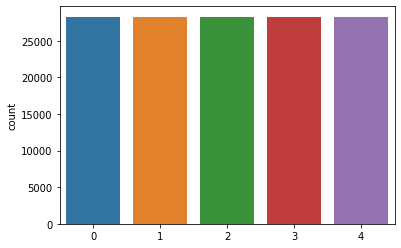

In [156]:
train_files, holdout_files = get_train_holdout_files(train_percentage=90)